### ~ 40 mins

In [1]:
#default_exp dicom2tensor

### set `data.yaml`

In [4]:
import yaml,os

In [67]:
os.environ['YAML_DATA']="/home/turgutluk/Vent_Seg_Project/dev/configs/data.yaml"

In [68]:
with open(os.environ.get('YAML_DATA', '../data.yaml')) as f: data_config = yaml.load(f.read(), yaml.FullLoader)

In [69]:
data_config

{'input': {'ATLAS_PATH': '/data/public/PICARE_BMETS_Raw_DICOM_Files',
  'MR_PATH': '/data/public/PICARE_SEGMENTATION_BRAINVENT_MR_V1',
  'CT_PATH': '/data/public/Training_CT_Raw_DICOM_Files',
  'MR_TEST2_PATH': '/data/public/Testing_MR_Raw_DICOM_Files',
  'CT_TEST2_PATH': '/data/public/Testing_CT_Raw_DICOM_Files'},
 'output': {'ATLAS': '/home/turgutluk/data/ventricles_data/atlas',
  'MR': '/home/turgutluk/data/ventricles_data/mr',
  'CT': '/home/turgutluk/data/ventricles_data/ct'},
 'csv_splits': {'ATLAS': '/home/turgutluk/data/ventricles_data/csvs/atlas_splits_df.csv',
  'MR': '/home/turgutluk/data/ventricles_data/csvs/mr_splits_df.csv',
  'CT': '/home/turgutluk/data/ventricles_data/csvs/ct_splits_df.csv'}}

### read -> interpolate/resample -> crop-pad -> save (Requires pydicom=> 1.4.0)

In [13]:
#export
from fastai2.medical.imaging_roi import *
from fastai2.medical.imaging import dicom_windows
from fastai2 import *
from fastai2.torch_core import *
from fastai2.core import *
from fastai2.basics import *

In [14]:
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 20

In [15]:
# define input and output paths
input_paths = types.SimpleNamespace(
    ATLAS_PATH=data_config['input']['ATLAS_PATH'],
    MR_PATH=data_config['input']['MR_PATH'],
    CT_PATH=data_config['input']['CT_PATH'],
    MR_TEST2_PATH=data_config['input']['MR_TEST2_PATH'],
    CT_TEST2_PATH=data_config['input']['CT_TEST2_PATH'],
)

output_paths = types.SimpleNamespace(
    ATLAS=data_config['output']['ATLAS'],
    MR=data_config['output']['MR'],
    CT=data_config['output']['CT'])

### check  metadata

You may check metadata that is shared to explore data in depth. Files you should find are: `ATLAS_PATH_META.csv`, `CT_PATH_META.csv`, `CT_TEST2_PATH_META.csv`, `MR_PATH_META.csv`, `MR_TEST2_PATH_META.csv` - one metadata for each DICOM folder.

In [18]:
# from fastai2.medical.imaging import DcmDataset, DcmMultiValue, _split_elem, _dcm2dict
# def _cast_dicom_special(x):
#     cls = type(x)
#     if not cls.__module__.startswith('pydicom'): return x
#     if cls.__base__ == object: return str(x)
#     return cls.__base__(x)
# @patch
# def as_dict2(self:DcmDataset, px_summ=True, multival=False):
#     pxdata = (0x7fe0,0x0010)
#     vals = [self[o] for o in self.keys() if o != pxdata]
#     its = [(v.keyword,v.value) for v in vals if not (not multival and isinstance(v.value,DcmMultiValue))]
#     res = dict(its)
#     res['fname'] = self.filename
#     for k,v in its: _split_elem(res,k,v)
#     for k in res: res[k] = _cast_dicom_special(res[k])
#     return res
# def _dcm2dict2(o): return o.dcmread().as_dict2(px_summ=False)

In [8]:
# # create metadata csv file for each folder
# paths = ("ATLAS_PATH MR_PATH CT_PATH MR_TEST2_PATH CT_TEST2_PATH").split()
# for o in paths:
#     PATH = data_paths.__dict__[o]
#     all_dcm_files = get_files(PATH, extensions=['.dcm'])
#     metadf = pd.DataFrame(parallel(_dcm2dict2, all_dcm_files))
#     metadf.to_csv(DATA_PATH/f"{o}_META.csv", index=False)

In [20]:
# put directory path where you store them
META_PATH = Path("/home/turgutluk/data/ventricles_data/csv_meta/")

In [21]:
csvs = get_files(META_PATH, extensions=[".csv"]); list(csvs)

[PosixPath('/home/turgutluk/data/ventricles_data/csv_meta/CT_PATH_META.csv'),
 PosixPath('/home/turgutluk/data/ventricles_data/csv_meta/MR_PATH_META.csv'),
 PosixPath('/home/turgutluk/data/ventricles_data/csv_meta/MR_TEST2_PATH_META.csv'),
 PosixPath('/home/turgutluk/data/ventricles_data/csv_meta/CT_TEST2_PATH_META.csv'),
 PosixPath('/home/turgutluk/data/ventricles_data/csv_meta/ATLAS_PATH_META.csv')]

In [22]:
# get unique study instance in each folder
for o in csvs: 
    df = pd.read_csv(o, low_memory=False)
    print(o.name, len(np.unique(df['StudyInstanceUID'])))

CT_PATH_META.csv 164
MR_PATH_META.csv 150
MR_TEST2_PATH_META.csv 20
CT_TEST2_PATH_META.csv 20
ATLAS_PATH_META.csv 2172


In [23]:
# explore metadata as you like
df.head()

,Unnamed: 0,SpecificCharacterSet,InstanceCreationDate,InstanceCreationTime,SOPClassUID,SOPInstanceUID,StudyDate,SeriesDate,StudyTime,SeriesTime,AccessionNumber,Modality,Manufacturer,InstitutionName,ReferringPhysicianName,StationName,StudyDescription,SeriesDescription,OperatorsName,ManufacturerModelName,PatientName,PatientID,PatientBirthDate,PatientSex,PatientAge,SoftwareVersions,StudyInstanceUID,SeriesInstanceUID,StudyID,SeriesNumber,StructureSetLabel,StructureSetName,StructureSetDate,StructureSetTime,ApprovalStatus,Unnamed: 35,fname,AcquisitionDate,ContentDate,AcquisitionTime,ContentTime,DerivationDescription,ScanningSequence,SequenceVariant,ScanOptions,MRAcquisitionType,SliceThickness,RepetitionTime,EchoTime,InversionTime,EchoTrainLength,ProtocolName,TriggerTime,FlipAngle,PatientPosition,AcquisitionNumber,InstanceNumber,FrameOfReferenceUID,Laterality,TemporalPositionIdentifier,NumberOfTemporalPositions,PositionReferenceIndicator,SliceLocation,SamplesPerPixel,PhotometricInterpretation,Rows,Columns,BitsAllocated,BitsStored,HighBit,PixelRepresentation,WindowCenter,WindowWidth,PatientWeight,ContrastBolusAgent,ContrastBolusRoute,LossyImageCompression,ContrastBolusVolume,ContrastBolusTotalDose,ContrastBolusIngredientConcentration
0,0,ISO_IR 192,20181217,234621.960,1.2.840.10008.5.1.4.1.1.481.3,2.16.840.1.114362.1.11785856.22571727257.502869102.1092.155,19990223,20181217,0.0,234621.960,NaN,RTSTRUCT,MIM Software Inc.,NaN,NaN,NaN,NaN,"MR Bias Corrected, axial_g",NaN,MIM,Anon^0243,BrainMets-UCSF-00488,NaN,M,NaN,6.9.0,2.16.840.1.114362.1.11782787.21988995044.495771394.898.9793,2.16.840.1.114362.1.11785856.22571727257.502869102.1092.155,Ldmf77nF,1,RTstruct,"MR Bias Corrected, axial_g",20181217.0,234621.106,UNAPPROVED,b'Others',"/data/public/PICARE_BMETS_Raw_DICOM_Files/1999-02__Studies/2.16.840_898.9793_RTst_1999-02-23_000000_._MR.Bias.Corrected,.axial.g_n1__00000/2.16.840.1.114362.1.11785856.22571727257.502869102.1092.155.dcm",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,ISO_IR 192,20181217,234822.716,1.2.840.10008.5.1.4.1.1.481.3,2.16.840.1.114362.1.11785856.22571730314.502869223.712.146,19990208,20181217,0.0,234822.716,NaN,RTSTRUCT,MIM Software Inc.,NaN,NaN,NaN,NaN,"MR Bias Corrected, axial",NaN,MIM,Anon^0144,BrainMets-UCSF-00124,NaN,F,NaN,6.9.0,2.16.840.1.114362.1.11782787.21988995044.495702410.544.9811,2.16.840.1.114362.1.11785856.22571730314.502869223.712.146,dkVgTnwb6Z5j,1,RTstruct,"MR Bias Corrected, axial",20181217.0,234822.725,UNAPPROVED,b'Others',"/data/public/PICARE_BMETS_Raw_DICOM_Files/1999-02__Studies/2.16.840_544.9811_RTst_1999-02-08_000000_._MR.Bias.Corrected,.axial_n1__00000/2.16.840.1.114362.1.11785856.22571730314.502869223.712.146.dcm",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,ISO_IR 192,20181217,234539.275,1.2.840.10008.5.1.4.1.1.481.3,2.16.840.1.114362.1.11785856.22571726225.502869060.271.140,19990224,20181217,0.0,234539.275,NaN,RTSTRUCT,MIM Software Inc.,NaN,NaN,NaN,NaN,"MR Bias Corrected, axial",NaN,MIM,Anon^0043,BrainMets-UCSF-00048,NaN,F,NaN,6.9.0,2.16.840.1.114362.1.11782787.21988995044.495701453.1021.8465,2.16.840.1.114362.1.11785856.22571726225.502869060.271.140,ix543i76LK21,1,RTstruct,"MR Bias Corrected, axial",20181217.0,234539.284,UNAPPROVED,b'Others',"/data/public/PICARE_BMETS_Raw_DICOM_Files/1999-02__Studies/2.16.840_021.8465_RTst_1999-02-24_000000_._MR.Bias.Corrected,.axial_n1__00000/2.16.840.1.114362.1.11785856.22571726225.502869060.271.140.dcm",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,ISO_IR 192,20181217,234619.319,1.2.840.10008.5.1.4.1.1.4,2.16.840.1.114362.1.11785856.22571727257.502869100.607.110,19990223,

### images and masks

In [24]:
#export
def create_voxel_mask(image_ds_list, refid2masks):
    voxel_mask = []
    for img_ds in image_ds_list:
        refid = img_ds[dicom_tags.sop_instance_uid].value
        if refid in refid2masks: voxel_mask += [refid2masks[refid]]
        else: voxel_mask += [torch.zeros(img_ds.shape, dtype=torch.uint8)]
    voxel_mask = torch.stack(voxel_mask); voxel_mask.shape
    return voxel_mask

In [25]:
#export
def collect_study_datasets(dcm_datasets):
    "collect study datasets by study instance uid key"
    study_datasets = defaultdict(list)
    for o in dcm_datasets: 
        if o.modality == dicom_modality.rtstruct: 
            study_datasets[o[dicom_tags.study_instance_uid].value].append(o)
        elif o.modality in [dicom_modality.ct, dicom_modality.mr]: 
            study_datasets[o[dicom_tags.study_instance_uid].value].append(o)
        else: raise Exception(f"Unknown modality: {o.modality} in DcmDataset")
    return study_datasets

In [26]:
#export
def separate_instance_datasets(instance_datasets):
    "separate instance datasets into RTSTRUCT and image"
    struct_ds_list, image_ds_list = [],[]
    for o in instance_datasets:
        if o.modality == dicom_modality.rtstruct: 
            struct_ds_list.append(o)
        elif o.modality in [dicom_modality.ct, dicom_modality.mr]:  
            image_ds_list.append(o)
    # pick first as struct ds
    struct_ds = struct_ds_list[0]
    return (struct_ds, image_ds_list)

In [27]:
#export
ROI = types.SimpleNamespace(brain="Brain", ventricles="Ventricles")    

In [28]:
#export
def resample_voxel(x, scale_factor):
    "resamples 3D tensor x with scale_factor (z,y,x)"
    return F.interpolate(x[None,None,...].float(), scale_factor=scale_factor)[0,0]

In [29]:
#export
def center_crop_pad(x, targ_sz=(128,256,256)):
    "do center crop or pad to transform to targ_sz"
    x = x.clone()
    targ_sz = array(targ_sz)
    size = array(x.shape)
    cnt = size//2
    z1,x1,y1,z2,x2,y2 = (*cnt - targ_sz//2, *cnt + targ_sz//2)
    if (x1 > 0) and (y1 > 0):       x = x[:,x1:x2,y1:y2]
    elif (x1 > 0) and (y1 <= 0):    x = F.pad(x[:,x1:x2,:], (-y1,-y1))
    elif (x1 <= 0) and (y1 > 0):    x = F.pad(x[:,:,y1:y2], (0,0,-x1,-x1))
    else:                           x = F.pad(x, (-y1,-y1,-x1,-x1)) 
   
    if z1 > 0: x = x[z1:z2]
    else: x = F.pad(x, (0,0,0,0,-z1,-z1))
    
    if list(x.shape) != list(targ_sz):
        resz, resy, resx = array(x.shape) - array(targ_sz)
        if resx == 1: x = x[:,:,1:]
        elif resx == -1: x = F.pad(x, (0,1))
            
        if resy == 1: x = x[:,1:,:]
        elif resy == -1: x = F.pad(x, (0,0,0,1))
        
        if resz == 1: x = x[1:,:,:]
        elif resz == -1: x = F.pad(x, (0,0,0,0,0,1))
    
    try:
        assert list(x.shape) == list(targ_sz)
    except:
        raise Exception(x.shape)
    finally:
        return x

In [30]:
#export
def create_and_save_img_mask(instance_datasets, output_path, resample_to=(1,1,3)):
    "save image and masks of a single study instance"
    struct_ds, image_ds_list = separate_instance_datasets(instance_datasets)
    study_instance_uid = struct_ds[dicom_tags.study_instance_uid].value
    if (ROI.brain not in struct_ds.roi_names) and (ROI.ventricles not in struct_ds.roi_names): return
    brain_contour_refdict = struct_ds.contour_refdict(ROI.brain)
    ventricles_contour_refdict = struct_ds.contour_refdict(ROI.ventricles)

    # image voxel
    refid2img_ds = {img_ds[dicom_tags.sop_instance_uid].value:img_ds for img_ds in image_ds_list}
    image_ds_list = sorted(image_ds_list, key=lambda o: int(o['InstanceNumber'].value))
    voxel_image = torch.stack([img_ds.windowed(*dicom_windows.brain) if img_ds.modality == dicom_modality.ct
                               else img_ds.pixels for img_ds in image_ds_list])

    # brain mask voxel
    refid2masks = {}
    for refid, contourdata in brain_contour_refdict.items(): 
        ref_ds = refid2img_ds[refid]
        refid2masks[refid] = tensor(sum([ref_ds.contourdata2mask(o) for o in contourdata]).astype(np.uint8))
    brain_voxel_mask = create_voxel_mask(image_ds_list, refid2masks)

    # ventricles mask voxel
    refid2masks = {}
    for refid, contourdata in ventricles_contour_refdict.items(): 
        ref_ds = refid2img_ds[refid]
        refid2masks[refid] = tensor(sum([ref_ds.contourdata2mask(o) for o in contourdata]).astype(np.uint8))
    ventricles_voxel_mask = create_voxel_mask(image_ds_list, refid2masks)
        
    # resample
    if resample_to is not None:
        image_ds = image_ds_list[0] # pick one image dataset for metadata
        scale_factor = image_ds.spacings[::-1] # z,y,x
        voxel_image = resample_voxel(voxel_image, scale_factor) 
        brain_voxel_mask = resample_voxel(brain_voxel_mask, scale_factor).byte()
        ventricles_voxel_mask = resample_voxel(ventricles_voxel_mask, scale_factor).byte()
    
    # save image and masks by study instance uid
    torch.save(voxel_image, output_path/f"{study_instance_uid}_image.pt")
    torch.save(brain_voxel_mask, output_path/f"{study_instance_uid}_brain_mask.pt")
    torch.save(ventricles_voxel_mask, output_path/f"{study_instance_uid}_ventricles_mask.pt")

In [31]:
#export
def save_study(study, output_path, **kwargs):
    try:
        dcm_files = get_files(study, extensions=['.dcm'])
        dcm_datasets = (o.dcmread() for o in dcm_files)
        study_datasets = collect_study_datasets(dcm_datasets)
        study_datasets = list((study_datasets).values())
        # save each instance in this study
        f = partial(create_and_save_img_mask, output_path=output_path, **kwargs)
        for o in study_datasets: f(o)
            
    except Exception as e:  
        print(f"{e}, study: {study}")

In [32]:
#export 
def _crop_pad_save(o, targ_sz):
    try:
        x = torch.load(o)
        x = center_crop_pad(x, targ_sz)
        torch.save(x, o)
    except: pass

### `[notebook run #1]` : `read -> convert2tensor -> resample -> save` 

You can use the following cells to prepare data using notebooks. The following cells will read studies in parallel convert DICOM files to Pytorch tensors, resample them to (1,1,3) - you may use different resampling dimension and finally save them into output path. At the end you will have `images`, `brain masks` and `ventricle masks` saved.

In [39]:
# You may change input path and output path accordingly - where to read from and write to
# Let's read from MR_PATH in input_paths and write to MR output_paths
input_path = Path(input_paths.MR_PATH)
output_path = Path(output_paths.MR)

studies = input_path.ls()
os.makedirs(output_path, exist_ok=True)

In [43]:
print(f"Total number of studies in {input_path}: {len(studies)}")

Total number of studies in /data/public/PICARE_SEGMENTATION_BRAINVENT_MR_V1: 107


In [38]:
# # test single study
# %%time
# study = studies[0]
# save_study(study, output_path)

In [295]:
%%time
# This code is parallelized to process each study in parallel, 
# processing time can vary depending on your hardware

# ATLAS: 15 mins with resample n_workers=defaults.cpus//4
# MR: 2 mins create, interpolate, crop-pad
# CT: 3 min with resample n_workers=defaults.cpus//4
f = partial(save_study, output_path=output_path, reample=(1,1,3))
parallel(f, studies, n_workers=defaults.cpus//4)

'FileDataset' object has no attribute 'PixelData', study: /data/public/PICARE_SEGMENTATION_BRAINVENT_MR_V1/2014-04__Studies
CPU times: user 215 ms, sys: 287 ms, total: 502 ms
Wall time: 1min 11s


(#107) [None,None,None,None,None,None,None,None,None,None...]

### `[notebook run #2]` - `read -> crop-pad -> save` 

Once you run `notebook run - 1` part above that will mean that you have prepared and saved pytorch tensors. Now we can run the code below to crop pad these tensors to make them all have same dimension in order to later put them into batches. If we don't crop-pad tensors to same dimensions we can't collate them into match as sizes won't match. 

In [44]:
# Get files that we saved above
files = get_files(output_path, extensions=['.pt'])

In [48]:
print(f"There are {len(files)} study instance tensors saved in: {output_path}")

There are 1002 study instance tensors saved in: /home/turgutluk/data/ventricles_data/mr


In [316]:
# Run this cell to crop-pad tensors in parallel - you can pick any `targ_sz`: target size
# We will leave (128, 256, 256) as our default for z,y,x (slice num, height, width) dimensions
targ_sz=(128,256,256)
f = partial(_crop_pad_save, targ_sz=targ_sz)
parallel(f, files, n_workers=defaults.cpus//4)

(#444) [None,None,None,None,None,None,None,None,None,None...]

In [317]:
# check all files to validate they all indeed have same target size of `targ_sz`
for o in files: list(torch.load(o).shape) == [128,256,256]

### `script` - Don't execute cells below!

These cells are converted into a python script in `local/dicom2tensor.py` which you can use instead of running in noteboook

In [8]:
#export 
import yaml
with open(os.environ.get('YAML_DATA', '../data.yaml')) as f: data_config = yaml.load(f.read(), yaml.FullLoader)

# define input and output paths
input_paths = types.SimpleNamespace(
    ATLAS_PATH=data_config['input']['ATLAS_PATH'],
    MR_PATH=data_config['input']['MR_PATH'],
    CT_PATH=data_config['input']['CT_PATH'],
    MR_TEST2_PATH=data_config['input']['MR_TEST2_PATH'],
    CT_TEST2_PATH=data_config['input']['CT_TEST2_PATH'],
)

output_paths = types.SimpleNamespace(
    ATLAS=data_config['output']['ATLAS'],
    MR=data_config['output']['MR'],
    CT=data_config['output']['CT'])

In [ ]:
#export 
from time import perf_counter
@call_parse
def main(input_path:Param("Data to prepare", str),
         output_path:Param("Data to prepare", str),
         resample_to:Param("Resample dimensions in mm", tuple)=(1,1,3),
         targ_sz:Param("Final crop pad dimensions", tuple)=(128,256,256)
        ):
    "Read DICOM from input_path and save image-mask tensors to output_path"

    start = perf_counter()
    
    # get input and output paths
    input_path, output_path = input_paths.__dict__[input_path], output_paths.__dict__[output_path]
    input_path, output_path = Path(input_path), Path(output_path)
    os.makedirs(output_path, exist_ok=True)
    print(f"reading from {str(input_path)}\nwriting to {str(output_path)}")
   
    # read, interpolate
    print("Read, create, interpolate and save")
    studies = input_path.ls()
    f = partial(save_study, output_path=output_path, resample_to=resample_to)
    parallel(f, studies, n_workers=defaults.cpus//4)
    
    # crop - pad and save
    print("Read, crop-pad and save")
    files = get_files(output_path, extensions=['.pt'])
    f = partial(_crop_pad_save, targ_sz=targ_sz)
    parallel(f, files, n_workers=defaults.cpus//4)
    
    end = perf_counter()
    print(f"Total time taken {end-start} seconds")

### Export

In [72]:
from local.notebook.export import notebook2script
notebook2script("1a) dicom to tensor.ipynb")

Converted 1a) dicom to tensor.ipynb.


### Visualize

You may visualize tensors saved

In [56]:
#export
def _plot_voxel(voxel):
    n = int(np.ceil(np.sqrt(len(voxel))))
    fig,axes = plt.subplots(n,n,figsize=(4*n,4*n))
    for i,(arr,ax) in enumerate(zip(voxel,axes.flatten())): 
        ax.imshow(arr); ax.set_title(str(i)); ax.set_xticks([]); ax.set_yticks([])

In [57]:
output_path = Path(output_paths.MR)

In [58]:
images_and_masks = output_path.ls()

In [59]:
images_and_masks

(#1002) [/home/turgutluk/data/ventricles_data/mr/2.16.840.1.114362.1.11741058.21988995044.484873375.140.4114_skull_stripped_image_normalized.pt,/home/turgutluk/data/ventricles_data/mr/2.16.840.1.114362.1.11741058.21988995044.484726770.896.3077_skull_stripped_image_normalized.pt,/home/turgutluk/data/ventricles_data/mr/2.16.840.1.114362.1.11741058.21988995044.484791583.866.8004_brain_mask.pt,/home/turgutluk/data/ventricles_data/mr/2.16.840.1.114362.1.11741058.21988995044.484726854.615.3528_image_normalized.pt,/home/turgutluk/data/ventricles_data/mr/2.16.840.1.114362.1.11741058.21988995044.486778702.402.1956_brain_mask.pt,/home/turgutluk/data/ventricles_data/mr/2.16.840.1.114362.1.11741058.21988995044.484728780.561.7428_image.pt,/home/turgutluk/data/ventricles_data/mr/2.16.840.1.114362.1.11741058.21988995044.486780005.568.3239_ventricles_mask.pt,/home/turgutluk/data/ventricles_data/mr/2.16.840.1.114362.1.11785856.21988995044.507668442.154.6402_ventricles_mask.pt,/home/turgutluk/data/ventr

In [60]:
study_instance_uids = images_and_masks.map(lambda o: o.name.split("_")[0])

In [61]:
# extract tensor size counts - check to see all tensors have same exact size
from tqdm.notebook import tqdm
sizes = []
for suid in tqdm(study_instance_uids): 
    img = torch.load(output_path/f"{suid}_brain_mask.pt")
    size = img.shape
    sizes.append(size)
size_counts = Counter(sizes)
size_counts.most_common(200)

[(torch.Size([128, 256, 256]), 1002)]

In [62]:
# pick a random study instance to visualize it's image, brain mask and ventricle mask
suid = np.random.choice(study_instance_uids)
voxel_image = torch.load(output_path/f"{suid}_image.pt")
brain_voxel_mask = torch.load(output_path/f"{suid}_brain_mask.pt")
ventricles_voxel_mask = torch.load(output_path/f"{suid}_ventricles_mask.pt")
voxel_image.shape, brain_voxel_mask.shape, ventricles_voxel_mask.shape

(torch.Size([128, 256, 256]),
 torch.Size([128, 256, 256]),
 torch.Size([128, 256, 256]))

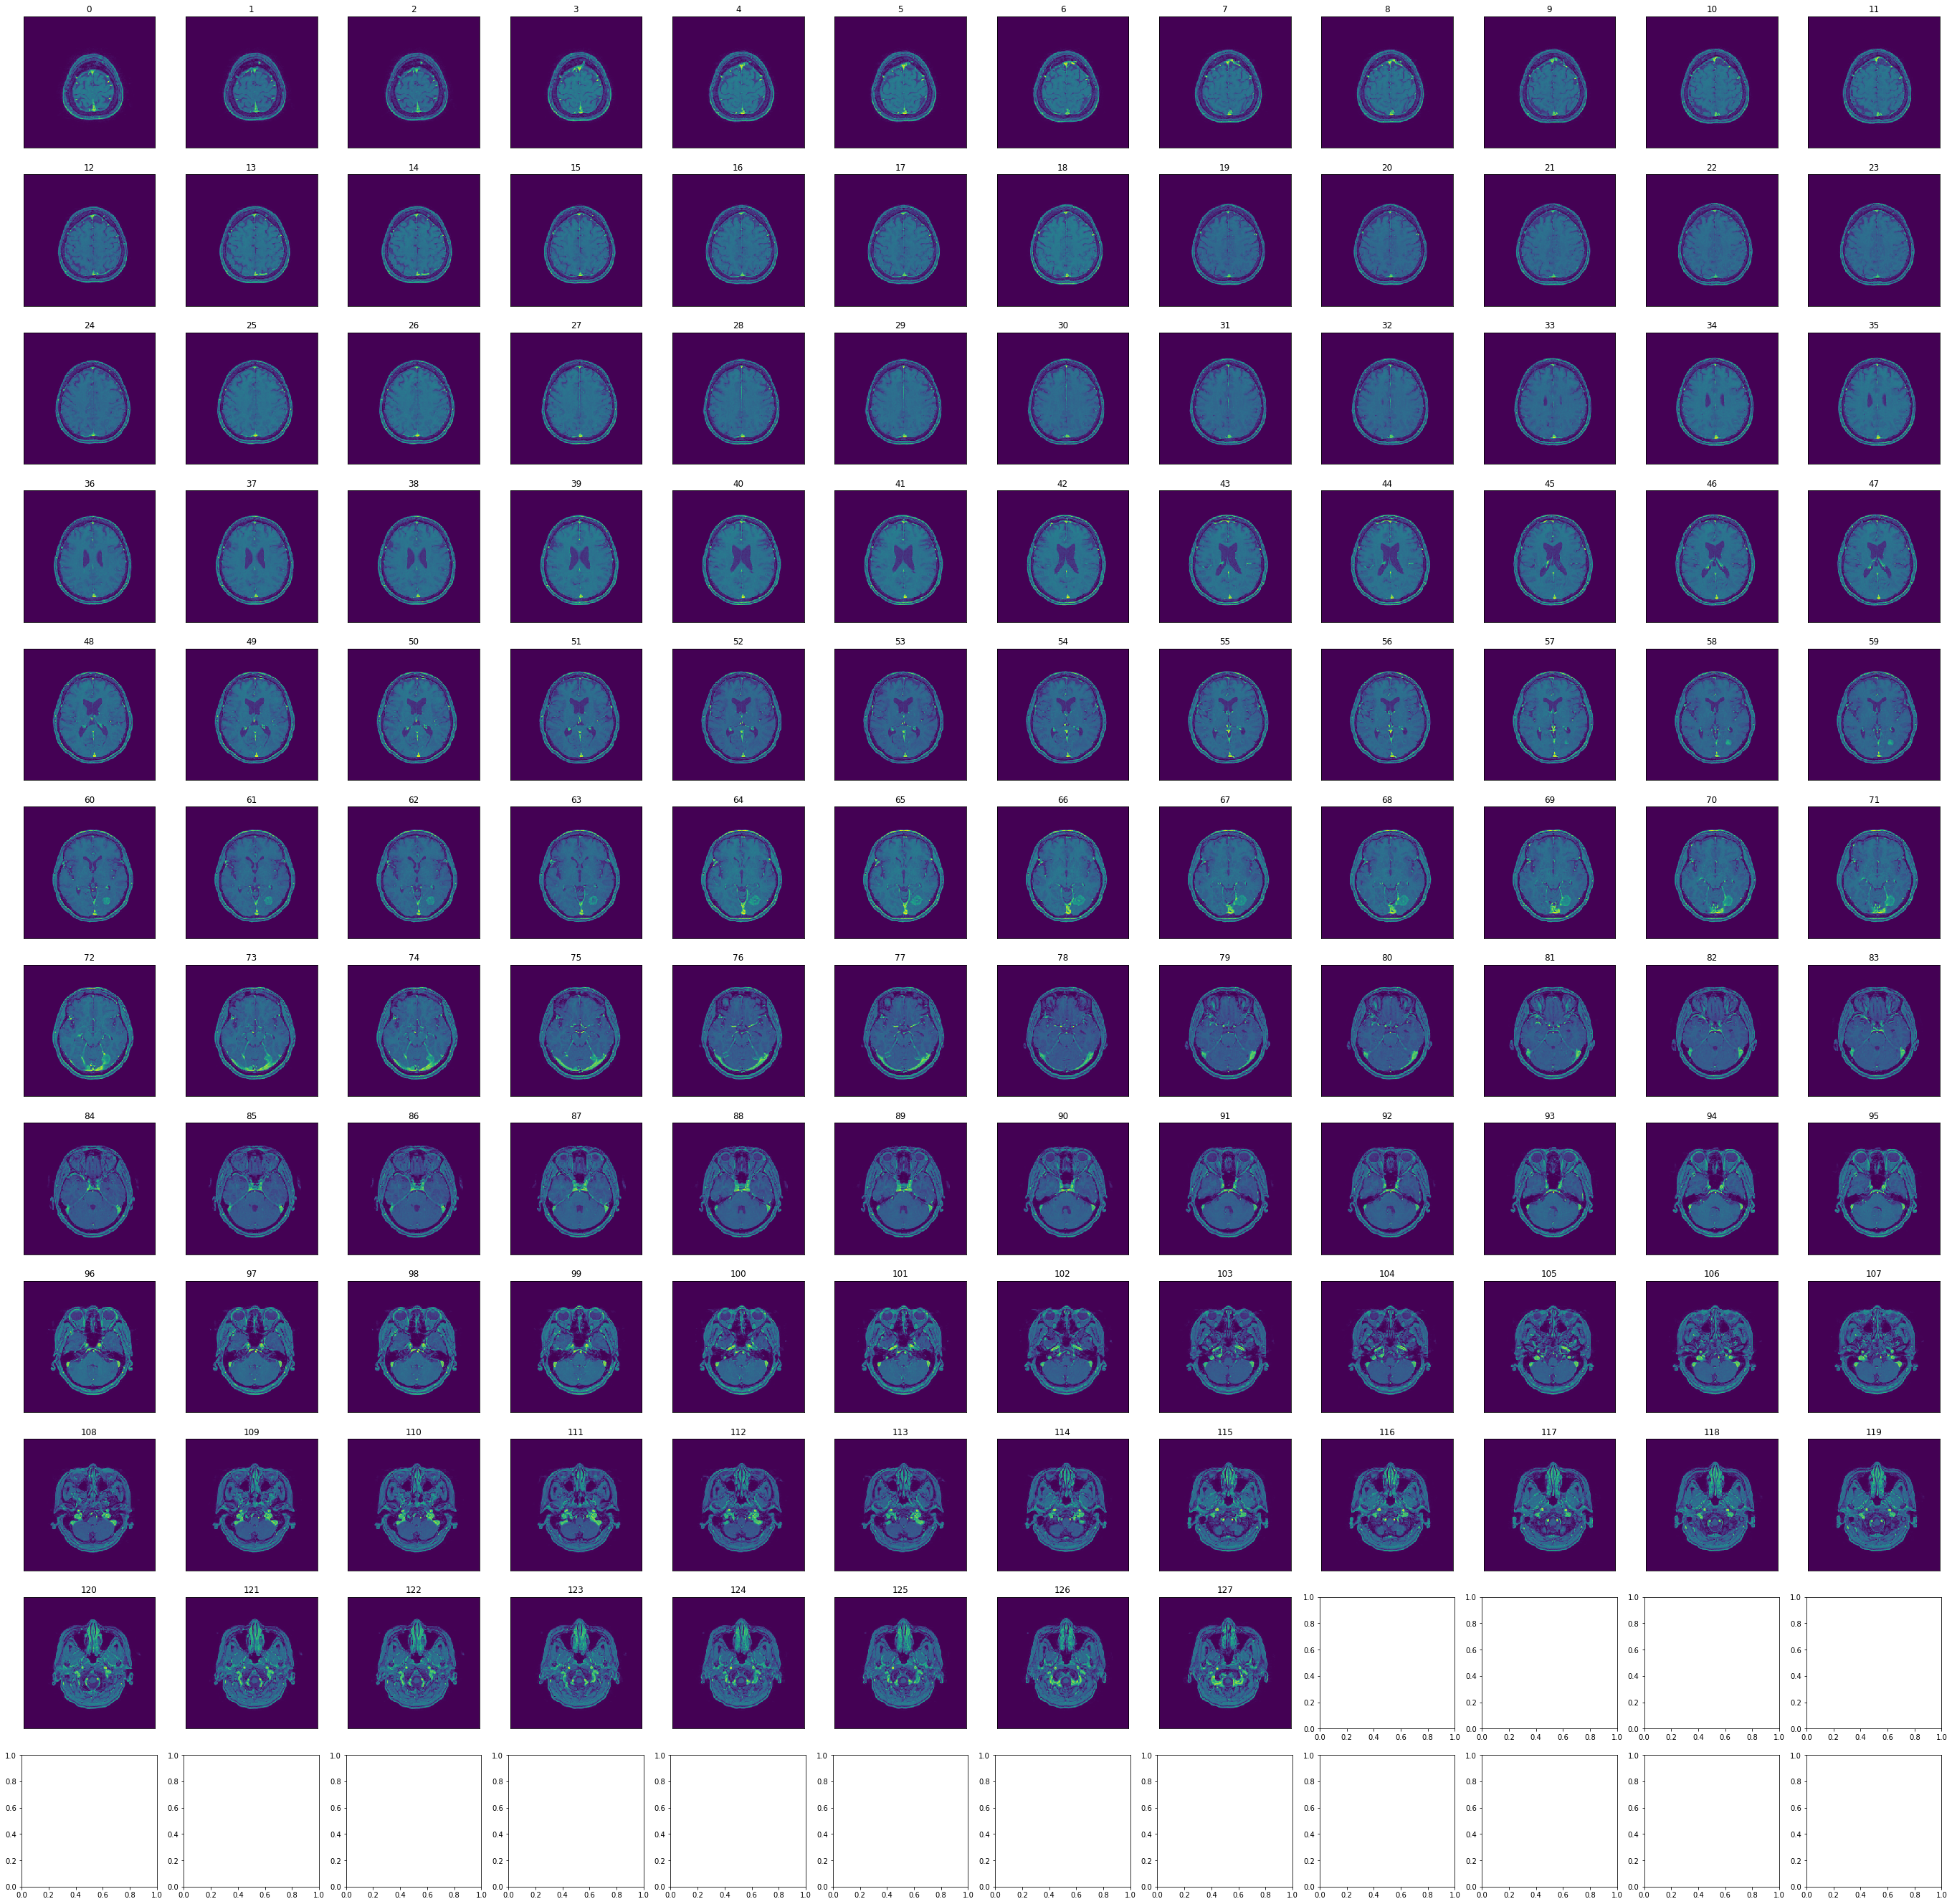

In [64]:
_plot_voxel(voxel_image)

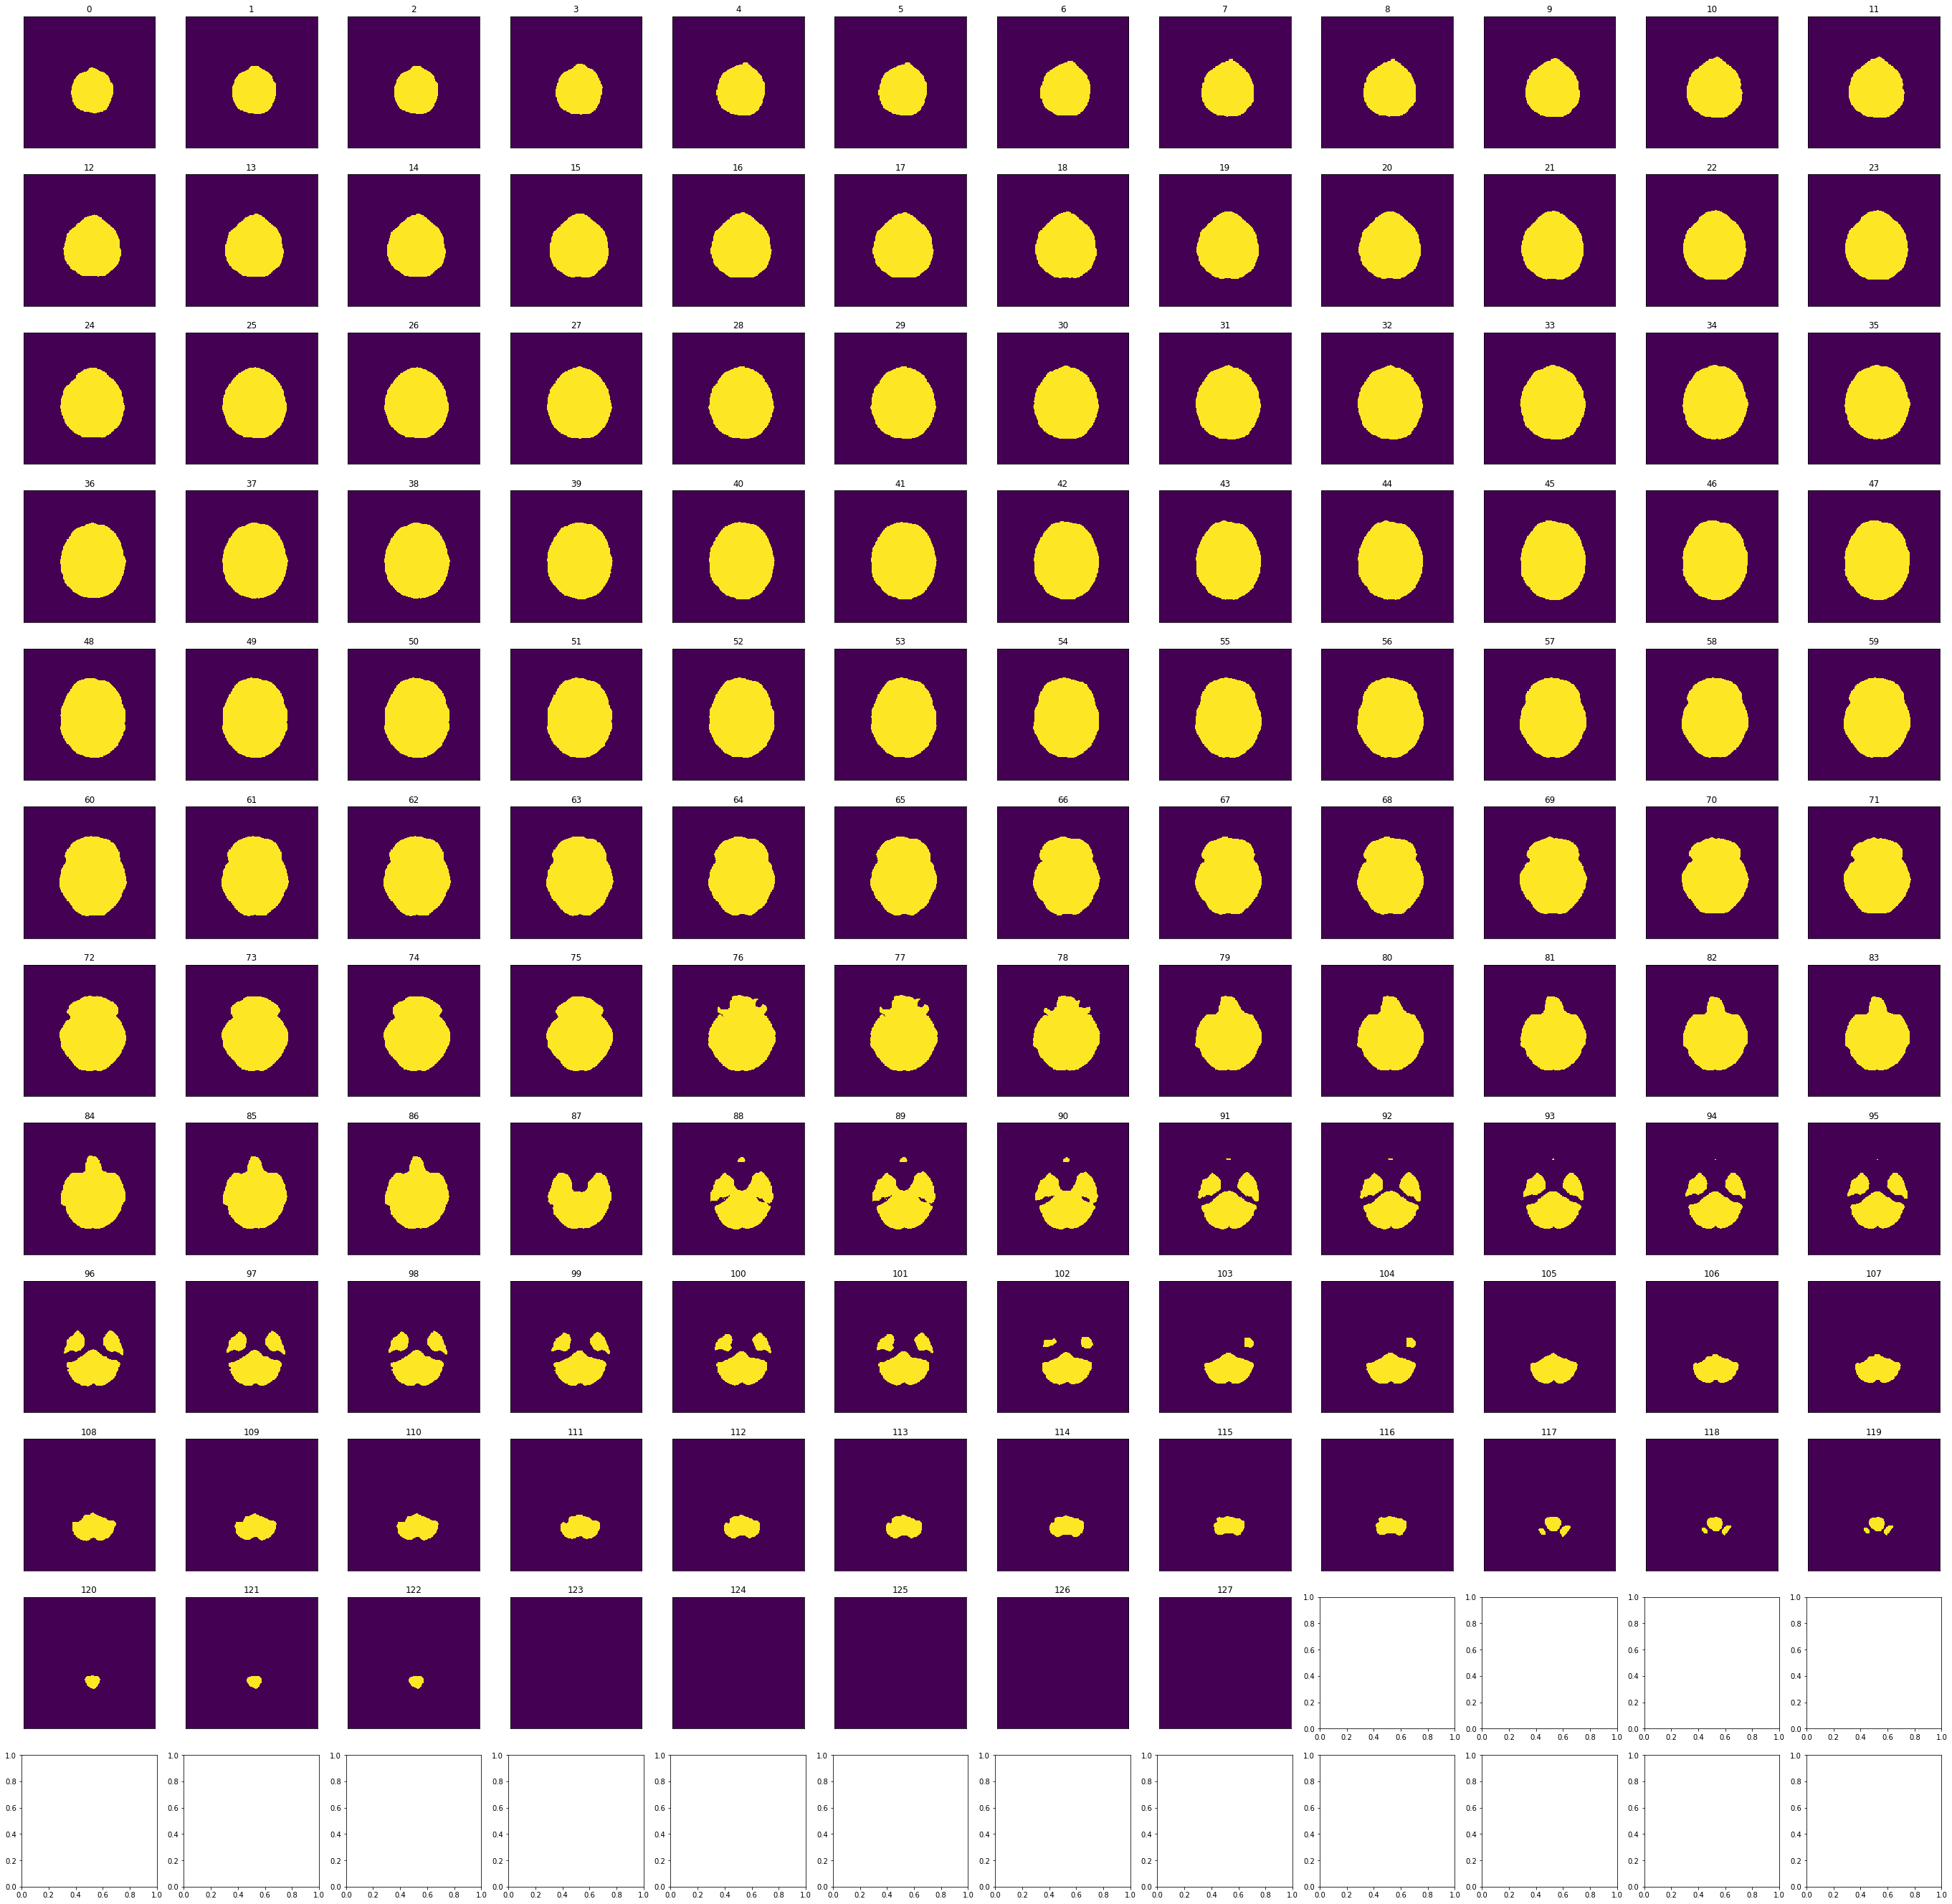

In [65]:
_plot_voxel(brain_voxel_mask)

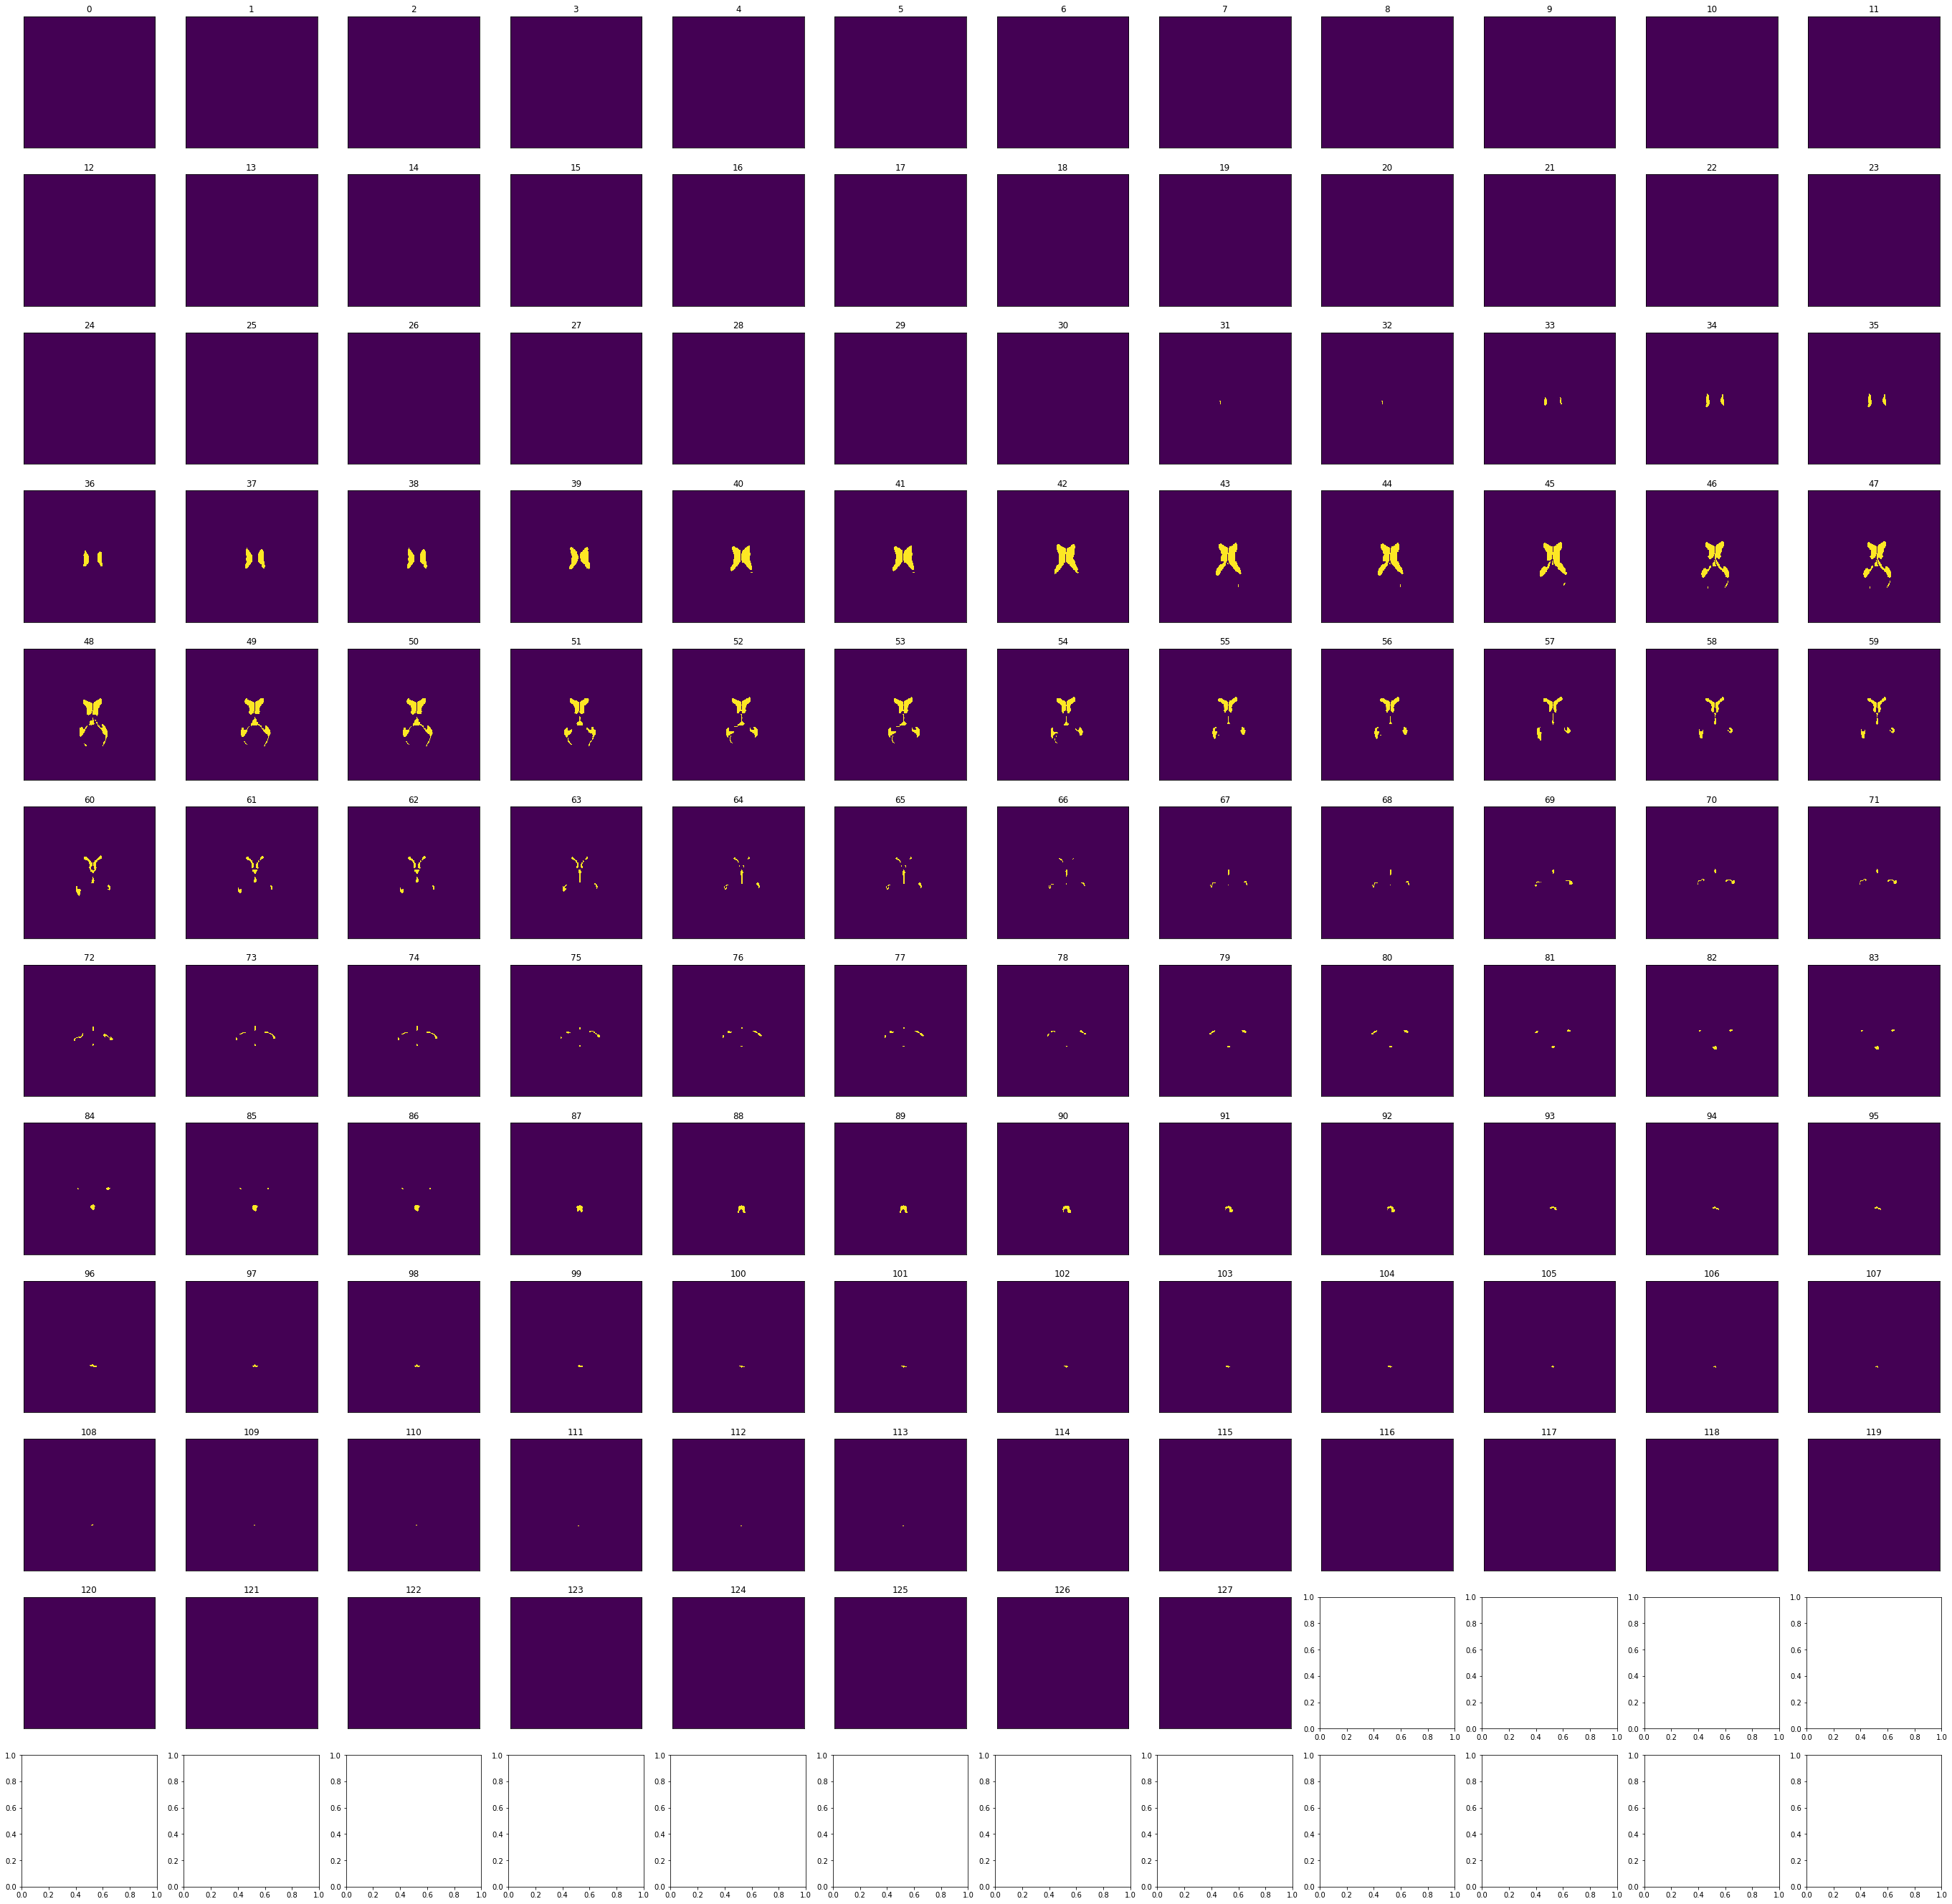

In [66]:
_plot_voxel(ventricles_voxel_mask)

### fin